In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0001

In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout untuk mengurangi overfitting
output = Dense(3, activation='softmax')(x)

In [5]:
model = Model(inputs=base_model.input, outputs=output)

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
import zipfile
with zipfile.ZipFile('/content/Dataset_Asli.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [8]:
dataset_path = '/content/Dataset_Asli'

In [9]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Folder tujuan untuk split data
train_path = os.path.join(dataset_path, 'train')  # Folder untuk train
test_path = os.path.join(dataset_path, 'test')    # Folder untuk test

# Buat folder untuk data train dan test jika belum ada
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Ambil semua folder kelas dalam dataset (misalnya adon_adon_coro, horok_horok, pindang_serani)
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d)) and d not in ['train', 'test']]

# Proses split untuk setiap kelas
for class_name in classes:
    class_folder = os.path.join(dataset_path, class_name)
    image_files = []

    # Menelusuri subfolder untuk menemukan file gambar
    for root, dirs, files in os.walk(class_folder):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):  # Pastikan file gambar
                image_files.append(os.path.join(root, file))

    # Check if the class folder contains any images
    if not image_files:
        print(f"Warning: Class '{class_name}' has no images. Skipping split.")
        continue  # Skip to the next class

    # Split data dengan proporsi 70:30
    train_files, test_files = train_test_split(image_files, test_size=0.3, random_state=42)

    # Folder tujuan untuk masing-masing kelas di dalam train dan test
    class_train_folder = os.path.join(train_path, class_name)
    class_test_folder = os.path.join(test_path, class_name)

    # Buat folder untuk kelas di train dan test jika belum ada
    os.makedirs(class_train_folder, exist_ok=True)
    os.makedirs(class_test_folder, exist_ok=True)

    # Pindahkan file gambar ke folder masing-masing
    for file in train_files:
        shutil.move(file, os.path.join(class_train_folder, os.path.basename(file)))

    for file in test_files:
        shutil.move(file, os.path.join(class_test_folder, os.path.basename(file)))

    # Tampilkan jumlah gambar di train dan test folder untuk setiap kelas
    num_train_images = len(os.listdir(class_train_folder))
    num_test_images = len(os.listdir(class_test_folder))

    print(f"Class: {class_name}")
    print(f"  - Number of images in train: {num_train_images}")
    print(f"  - Number of images in test: {num_test_images}")

Class: Horok_Horok
  - Number of images in train: 209
  - Number of images in test: 90
Class: Pindang_Serani
  - Number of images in train: 211
  - Number of images in test: 91
Class: Adon_Adon_Coro
  - Number of images in train: 210
  - Number of images in test: 91


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 505 images belonging to 3 classes.
Found 125 images belonging to 3 classes.


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4136 - loss: 1.1646 - val_accuracy: 0.7280 - val_loss: 0.7647
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 480ms/step - accuracy: 0.7097 - loss: 0.7501 - val_accuracy: 0.9120 - val_loss: 0.5184
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - accuracy: 0.8313 - loss: 0.5312 - val_accuracy: 0.9280 - val_loss: 0.4308
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.9065 - loss: 0.4135 - val_accuracy: 0.9120 - val_loss: 0.3479
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - accuracy: 0.8882 - loss: 0.3651 - val_accuracy: 0.9280 - val_loss: 0.3089
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 491ms/step - accuracy: 0.9098 - loss: 0.2948 - val_accuracy: 0.9200 - val_loss: 0.2781
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.9455 - loss: 0.2414 - val_accuracy: 0.9520 - val_loss: 0.2135
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 422ms/step - accuracy: 0.9531 - loss: 0.2217 - val_accuracy: 0.9

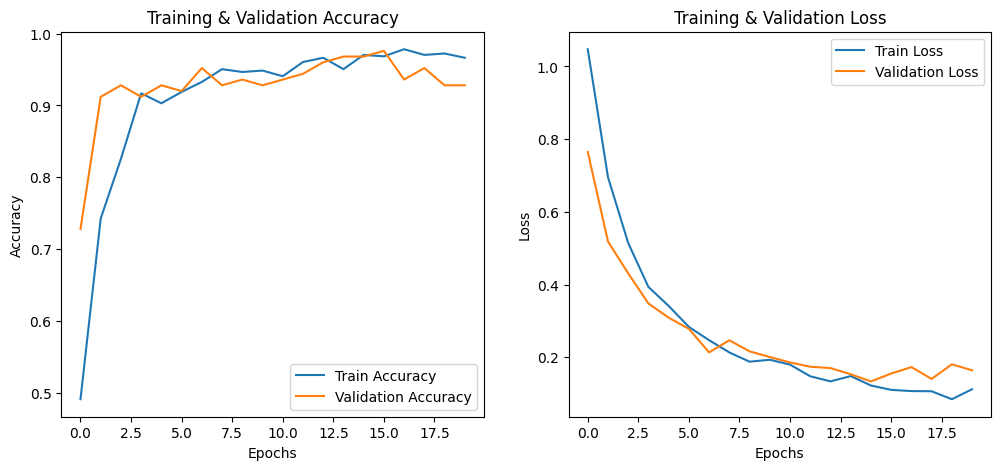

In [13]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.plot(history_finetune.history['accuracy'], label='Train Accuracy (Fine-tuning)')
# plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history_finetune.history['loss'], label='Train Loss (Fine-tuning)')
# plt.plot(history_finetune.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

In [14]:
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Hanya fine-tune 20 layer terakhir
    layer.trainable = False

In [15]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2

# Ambil layer terakhir sebelum output
x = base_model.output

x = GlobalAveragePooling2D()(x)

# Tambahkan Dropout
x = Dropout(0.3)(x)

# Tambahkan Dense layer dengan L2 Regularization
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output layer
output = Dense(3, activation='softmax')(x)  # Sesuaikan jumlah kelas

# Buat model baru dengan Functional API
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile ulang model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history_finetune = model.fit(
    train_generator,
    epochs=20,  # Tambahkan beberapa epoch, tapi bisa berhenti lebih awal
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3416 - loss: 5.5806 - val_accuracy: 0.3520 - val_loss: 5.3987
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.4147 - loss: 5.3867 - val_accuracy: 0.5840 - val_loss: 5.1609
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 489ms/step - accuracy: 0.5809 - loss: 5.1249 - val_accuracy: 0.6720 - val_loss: 5.0340
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - accuracy: 0.6912 - loss: 5.0088 - val_accuracy: 0.7280 - val_loss: 4.9564
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 483ms/step - accuracy: 0.7561 - loss: 4.9051 - val_accuracy: 0.7920 - val_loss: 4.8762
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - accuracy: 0.8406 - loss: 4.7658 - val_accuracy: 0.8320 - val_loss: 4.7822
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.8627 - loss: 4.6914 - val_accuracy: 0.8480 - val_loss: 4.7028
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.8946 - loss: 4.6357 - val_accuracy: 0.83

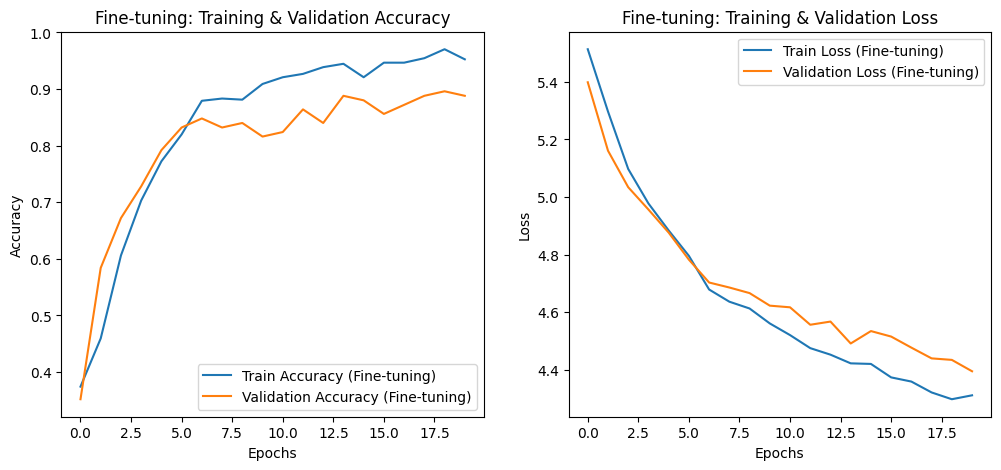

In [17]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy (Fine-tuning)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Fine-tuning: Training & Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss (Fine-tuning)')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Fine-tuning: Training & Validation Loss')

plt.show()

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
test_generator = test_datagen.flow_from_directory(
    test_path,  # Ganti dengan path folder test
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Jangan diacak agar prediksi bisa dibandingkan dengan label
)

Found 272 images belonging to 3 classes.


In [20]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - accuracy: 0.9612 - loss: 4.2546
Test Accuracy: 0.9338, Test Loss: 4.3173


In [21]:
# Evaluasi pada data test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Ambil validation accuracy dari hasil training terakhir
val_acc = history_finetune.history['val_accuracy'][-1]  # Ambil nilai validation accuracy dari epoch terakhir

print(f"Validation Accuracy: {val_acc:.4f}")

# Bandingkan Test Accuracy & Validation Accuracy
if abs(test_acc - val_acc) <= 0.02:  # Toleransi selisih 2%
    print("✅ Model masih generalizable (tidak overfitting)")
elif test_acc < val_acc:
    print("⚠️ Model kemungkinan overfitting! Test accuracy lebih rendah dari validation accuracy.")
else:
    print("ℹ️ Model bekerja baik di test set, tetapi tetap perlu dicek lebih lanjut.")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9612 - loss: 4.2546
Test Accuracy: 0.9338, Test Loss: 4.3173
Validation Accuracy: 0.8880
ℹ️ Model bekerja baik di test set, tetapi tetap perlu dicek lebih lanjut.


[INFO] Testing and evaluating...
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step
                precision    recall  f1-score   support

Adon_Adon_Coro       0.84      1.00      0.91        91
   Horok_Horok       1.00      0.91      0.95        90
Pindang_Serani       0.99      0.89      0.94        91

      accuracy                           0.93       272
     macro avg       0.94      0.93      0.93       272
  weighted avg       0.94      0.93      0.93       272



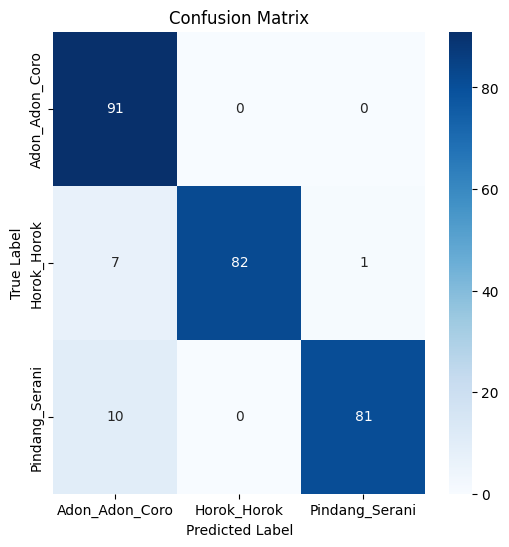

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("[INFO] Testing and evaluating...")

# Prediksi pada data uji
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Label sebenarnya
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Laporan klasifikasi
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

# Confusion Matrix
cm = confusion_matrix(true_classes, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Saving apindang133.jpeg to apindang133.jpeg


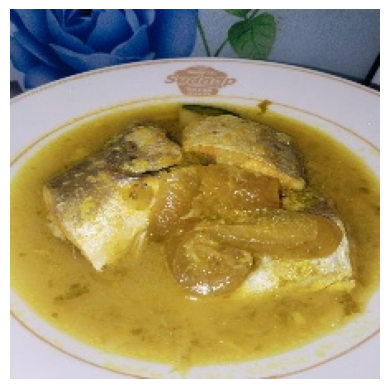

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
File: apindang133.jpeg
Predicted Class: Pindang_Serani
Confidence Score: 0.97


In [28]:
from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Pastikan img_height dan img_width sudah didefinisikan
img_height = 224  # Sesuaikan dengan ukuran input model
img_width = 224

# Upload file gambar
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn

    # Load gambar
    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))

    # Tampilkan gambar
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Konversi gambar ke array
    x = tf.keras.utils.img_to_array(img)
    x = tf.expand_dims(x, axis=0)  # Tambahkan batch dimension

    # Preprocessing jika model menggunakan MobileNetV2
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    # Prediksi kelas
    predictions = model.predict(x)

    # Ambil index kelas dengan confidence tertinggi
    predicted_class_index = np.argmax(predictions[0])
    confidence_score = np.max(predictions[0])  # Ambil confidence tertinggi

    # Ambil label kelas
    class_labels = list(train_generator.class_indices.keys())  # Label kelas dari train_generator

    # Tampilkan hasil prediksi
    print(f"File: {fn}")
    print(f"Predicted Class: {class_labels[predicted_class_index]}")
    print(f"Confidence Score: {confidence_score:.2f}")

In [33]:
model.save("jepara_food_classifier.h5", save_format="h5")

In [32]:
pip install h5py

In [34]:
pip freeze > requirements.txt